In [1]:
from datetime import datetime
print(f'Päivitetty {datetime.now()}')

Päivitetty 2021-11-07 10:56:30.464432


# Poikkeavien arvojen poistaminen

Muista selvästi poikkeavat arvot voivat olla virheellisiä tai todellisia.

Jos poikkeavat arvot osoittautuvat virheellisiksi, niin ne on syytä poistaa datasta. Kyseeseen voi tulla poikkeavia arvoja sisältävien rivien poisto, poikkeavien arvojen korvaaminen puuttuvan arvon merkillä tai korvaaminen esimerkiksi mediaanilla.

Vaikka poikkeavat arvot olisivat todellisia, niin niiden poistaminen voi olla aiheellista esimerkiksi ennustemallien rakentamisessa.

Poikkeavien arvojen kriteerinä voidaa pitää esimerkiksi seuraavia:
* Arvot, jotka ovat yli kolmen keskihajonnan päässä keskiarvostaan.
* Arvot, jotka ovat yli 1,5 neljännesvälin päässä neljänneksestä. Neljännesväli (inter quartile range) on yläneljänneksen ja alaneljänneksen erotus. Ruutu- ja janakaavioon (boxplot) yli 1,5 neljännesvälin päässä olevat arvot merkitään oletusarvoisesti erillisinä pisteinä.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [3]:
# Arvotaan normaalijakaumasta satunnaislukuja (tuhat riviä, neljä saraketta)
df = pd.DataFrame(np.random.randn(1000, 4))

In [4]:
df.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.011607,-0.036887,0.026013,0.031449
std,1.028500,0.986703,1.010202,0.983185
min,-4.114530,-3.069249,-3.496985,-2.936617
25%,-0.762319,-0.721525,-0.672077,-0.617186
50%,0.004835,-0.064189,0.010613,0.023360
75%,0.661369,0.614052,0.712109,0.701054
max,3.443252,2.949649,3.152644,2.743422


<AxesSubplot:>

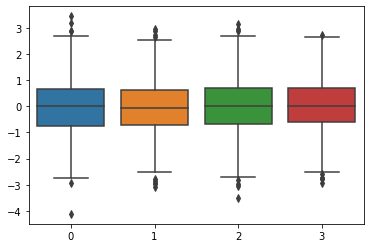

In [5]:
sns.boxplot(data = df)

## Rivien poisto

In [6]:
# Poistan poikkeavia arvoja (yli 3 keskihajonnan päässä keskiarvostaan) sisältävät rivit

df1 = df.copy()

for muuttuja in df1:
    
    ka = df[muuttuja].mean()
    kh = df[muuttuja].std()
    
    # Suodatan mukaan rivit, jotka ovat korkeintaan kolmen keskihajonnan päässä keskiarvostaan
    df1 = df1[abs(df1[muuttuja] - ka) <= 3 * kh]

# Tarkistan jäljelle jääneiden rivien lukumäärän
df1.shape[0]

991

In [7]:
# Poistan poikkeavia arvoja (yli 1,5 neljännesväliä neljänneksestä)

df2 = df.copy()

for muuttuja in df2:
    
    Q1 = df[muuttuja].quantile(0.25) # alaneljännes
    Q3 = df[muuttuja].quantile(0.75) # yläneljännes
    IQR = Q3 - Q1 # neljännesväli
    
    df2 = df2[((df2[muuttuja] >= (Q1 - 1.5 * IQR)) & (df2[muuttuja] <= (Q3 + 1.5 * IQR)))]

# Tarkistan jäljelle jääneiden rivien lukumäärän    
df2.shape[0]

972

## Korvaaminen puuttuvalla arvolla

**mask()** on tässä kätevä
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mask.html

In [8]:
# Yli kolmen keskihajonnan päässä keskiarvostaan sijaitsevat puuttuviksi arvoiksi

ka = df.mean()
kh = df.std()

df3 = df.mask(abs((df - ka) / kh) > 3)

# Tarkistan puuttuvien arvojen lukumäärät
df3.isnull().sum()

0    3
1    2
2    3
3    1
dtype: int64

In [9]:
# Yli 1.5 neljännesvälin päässä neljänneksestä sijaitsevat puuttuviksi arvoiksi

Q1 = df.quantile(0.25) # alaneljännes
Q3 = df.quantile(0.75) # yläneljännes
IQR = Q3-Q1

#df4 = df.mask(((df - Q3) / (Q3 - Q1) > 1.5) | ((Q1 - df) / (Q3 - Q1) > 1.5))
df4 = df.mask((df > Q3 + 1.5 * IQR) | ( df < Q1 - 1.5 * IQR))

# Tarkistan puuttuvien arvojen lukumäärät
df4.isnull().sum()

0    6
1    9
2    7
3    6
dtype: int64

## Korvaaminen toisella arvolla

In [10]:
# Korvaan poikkeavat arvot keskiarvolla

ka = df.mean()
kh = df.std()

df5 = df.mask((abs((df - ka)/kh)) > 3, other = ka, axis = 1)

# Tarkistan min ja max
df5.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.014150,-0.036841,0.029469,0.034417
std,1.009365,0.977471,0.994442,0.978686
min,-2.915918,-2.989429,-2.956451,-2.783593
25%,-0.761158,-0.718861,-0.671028,-0.616110
50%,-0.007279,-0.062964,0.017710,0.026703
75%,0.656439,0.610284,0.709917,0.701054
max,2.897429,2.893965,2.941183,2.743422


In [11]:
# Korvaan kaikki arvot, jotka ovat itseisarvoltaan yli 3, arvolla 3 tai -3

df6 = df.copy()

# sign tuottaa oikean etumerkin (+/-)
df6[abs(df6) > 3] = np.sign(df6) * 3

# Tarkistan min ja max
df6.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.011115,-0.036818,0.026391,0.031449
std,1.022703,0.986492,1.008024,0.983185
min,-3.000000,-3.000000,-3.000000,-2.936617
25%,-0.762319,-0.721525,-0.672077,-0.617186
50%,0.004835,-0.064189,0.010613,0.023360
75%,0.661369,0.614052,0.712109,0.701054
max,3.000000,2.949649,3.000000,2.743422


## Lisätietoa

Data-analytiikka Pythonilla: https://tilastoapu.wordpress.com/python/